# [Práctica 1 - Regresión](https://www.kaggle.com/competitions/ml-etsisi-precio-portatil)


**Índice**
1. [Carga de los datos de entrenamiento](#carga-de-datos-de-entrenamiento)
2. [Preprocesamiento](#preprocesamiento)
   1. [Variable objetivo](#separar-la-variable-objetivo)
   2. [Simplificación de features](#simplificaión-de-features)
   3. [Aplicación del preprocesamiento](#aplicación-del-preprocesamiento)
   4. [Análisis de las features](#análisis-de-las-features)
      1. [Features Continuas](#features-continuas)
      2. [Features Discretas](#features-discretas)
   5. [Transformación de las features](#transformación-de-las-features)
3. [Elección de regresores](#elección-de-regresores)
4. [Asignación del regresor](#asignación-regresor)
5. [Predicción](#predicción)

## Carga de los datos de entrenamiento
Lo primero que realizamos es la carga del dataset con el conjunto de datos que serán utilizados para entrenar el modelo.

In [2]:
import numpy as np
import pandas as pd
import sklearn.compose

data = pd.read_csv("Data/train.csv")
data.tail()

,LaptopId,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
907,994,Dell,Inspiron 5378,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.68kg,889.00
908,615,Asus,FX753VD-GC007T (i7-7700HQ/8GB/1TB,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050,Windows 10,3kg,1168.00
909,1063,Dell,Inspiron 5567,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,2TB HDD,AMD Radeon R7 M445,Windows 10,2.32kg,989.99
910,96,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,AMD Radeon R5 M430,Linux,2.2kg,599.90
911,539,Lenovo,Thinkpad E470,Notebook,14.0,IPS Panel Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,Nvidia GeForce 940MX,Windows 10,1.87kg,859.00


## Preprocesamiento

### Separar la variable objetivo
El primer paso del preprocesamiento será separar la variable objetivo del resto de features del dataframe.

In [3]:
y_data = data.iloc[:, -1]

### Simplificaión de features
Ahora, crearemos una función para poder aplicar el preprocesamiento siempre de la misma manera, tanto al dataframe del entrenamiento como al de test.

Esta función recibe por parametro el dataframe sin la variable objetivo y nos devuelve otro dataframe con el preprocesamiento aplicado, el preprocesamiento para los datos que tenemos consta de:

- Separar la columna 'ScreenResolution' en diferentes columnas que nos puedan aportar más información, como el tipo de pantalla, el formato, si es táctil o la cantidad de píxeles.
- Separar la columna 'Cpu' en otras que recojan la información sobre el modelo, la marca y la velocidad de reloj.
- Separar la columna 'Gpu' en otras que recojan la información sobre la marca, el modelo y si la gráfica está integrada o no.
- Separamos la columna 'Memory' segun el tipo de memoria del que disponga el ordenador y agrupamos la cantidad de memoria total reutilizando la columna.
- Convertimos todos los datos numéricos por columna a la misma unidad y eliminamos las unidades para poder evaluarlas como números.
- Por último, eliminamos aquellas columnas que ofrezcan información doble despues de haber separado las columnas y aquellas columnas auxiliares creadas durante el proceso.

De esta forma conseguimos que la información de una columna pueda tratarse de forma independiente al estar separada en varias columnas.

In [4]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame:
    def parseMemory(mem: str):
        ssd = 0
        hdd = 0
        hybrid = 0
        flash = 0

        if '+' in mem:
            first = mem.split('+')[0].strip()
            second = mem.split('+')[1].strip()

            disc1 = {first.split()[1].strip(): first.split()[0].strip()}
            disc2 = {second.split()[1].strip(): second.split()[0].strip()}
            
            if "TB" in list(disc1.values())[0]:
                gb = float(list(disc1.values())[0][:-2])*1000
            else:
                gb = int(list(disc1.values())[0][:-2])

            if "TB" in list(disc2.values())[0]:
                gb = float(list(disc2.values())[0][:-2])*1000
            else:
                gb = int(list(disc2.values())[0][:-2])

            if "SSD" in list(disc1.keys())[0]:
                ssd += gb
            elif "HDD" in list(disc1.keys())[0]:
                hdd += gb
            elif "Hybrid" in list(disc1.keys())[0]:
                hybrid += gb
            elif "Flash" in list(disc1.keys())[0]:
                flash += gb

            if "SSD" in list(disc2.keys())[0]:
                ssd += gb
            elif "HDD" in list(disc2.keys())[0]:
                hdd += gb
            elif "Hybrid" in list(disc2.keys())[0]:
                hybrid += gb
            elif "Flash" in list(disc2.keys())[0]:
                flash += gb
                
        else:
            disc1 = {mem.split()[1].strip(): mem.split()[0].strip()}
            if "TB" in list(disc1.values())[0]:
                gb = float(list(disc1.values())[0][:-2])*1000
            else:
                gb = int(list(disc1.values())[0][:-2])
            
            if "SSD" in list(disc1.keys())[0]:
                ssd += gb
            elif "HDD" in list(disc1.keys())[0]:
                hdd += gb
            elif "Hybrid" in list(disc1.keys())[0]:
                hybrid += gb
            elif "Flash" in list(disc1.keys())[0]:
                flash += gb

        return ssd, hdd, hybrid, flash

    data = data.replace({'Ram': r'GB', 'Weight': r'kg'},
                        {'Ram': '', 'Weight': ''}, regex=True)

    data["Touchscreen"] = data["ScreenResolution"].str.contains(
        "Touchscreen", regex=False)
    data = data.replace({'ScreenResolution': r'( \/ )?Touchscreen( \/ )?'},
                        {'ScreenResolution': ''}, regex=True)
    data = data.replace({'ScreenResolution': ' F'}, {
                        'ScreenResolution': 'F'}, regex=True)
    data = data.replace({'ScreenResolution': ' R'}, {
                        'ScreenResolution': 'R'}, regex=True)
    data = data.replace({'ScreenResolution': ' Q'}, {
                        'ScreenResolution': 'Q'}, regex=True)
    data["ScreenType"] = data["ScreenResolution"].str.split().str[:-
                                                                  1].str.join(" ")
    data["ScreenFormat"] = data["ScreenResolution"].str.split().str[-1]
    data["IPS"] = data["ScreenType"].str.contains("IPS", regex=False)
    data = data.replace({'ScreenType': 'IPS Panel'}, {
                        'ScreenType': ''}, regex=True)
    data["Pixels_b"] = data["ScreenFormat"].str.split('x').str[0]
    data["Pixels_h"] = data["ScreenFormat"].str.split('x').str[-1]
    data = data.astype({'Pixels_b': 'int', 'Pixels_h': 'int'})
    data["Pixels"] = data["Pixels_b"] * data["Pixels_h"]

    data = data.replace({'Cpu': r'GHz'}, {'Cpu': ''}, regex=True)

    data["Cpu_GHz"] = data["Cpu"].str.split().str[-1]
    data["Cpu_Manufacturer"] = data["Cpu"].str.split().str[0]
    data["Cpu_Model"] = data["Cpu"].str.split().str[1:-1].str.join(" ")

    data["Gpu_Manufacturer"] = data["Gpu"].str.split().str[0]
    data["Gpu_Model"] = data["Gpu"].str.split().str[1:].str.join(" ")
    data["Gpu_Integrated"] = data["Gpu_Manufacturer"].str.contains(
        "Intel|ARM", regex=True)

    data["Composite"] = data["Memory"].str.contains("+", regex=False)
    data["SSD"], data["HDD"], data["Hybrid"], data["Flash"] = zip(
        *data["Memory"].apply(parseMemory))

    data = data.astype({'Touchscreen': 'int', 'IPS': 'int', 'Composite': 'int', 'Ram': 'int', 'Weight': 'float', 'Cpu_GHz': 'float', 'Gpu_Integrated': 'int', 'SSD': 'int',
                       'HDD': 'int', 'Hybrid': 'int', 'Flash': 'int'})

    data["Memory"] = data["SSD"] + data["HDD"] + data["Hybrid"] + data["Flash"]

    data = data.drop(["LaptopId", "Product", "ScreenFormat",
                     "Pixels_b", "Pixels_h"], axis=1)
    return data


### Aplicación del preprocesamiento
Aplicamos el preprocesamiento pasando por parámetro el dataframe sin la variable objetivo e imprimimos las columnas resultantes para analizar su distribución

In [5]:
pd.options.mode.chained_assignment = None
x_data = preprocess(data.iloc[:, :-1])
x_data.columns

Index(['Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram',
       'Memory', 'Gpu', 'OpSys', 'Weight', 'Touchscreen', 'ScreenType', 'IPS',
       'Pixels', 'Cpu_GHz', 'Cpu_Manufacturer', 'Cpu_Model',
       'Gpu_Manufacturer', 'Gpu_Model', 'Gpu_Integrated', 'Composite', 'SSD',
       'HDD', 'Hybrid', 'Flash'],
      dtype='object')

### Análisis de las features

#### Features continuas
Mostramos los gráficos de densidad y los gráficos de caja y bigotes para ver la distribución y los outliers.

Inches        AxesSubplot(0.125,0.747241;0.352273x0.132759)
Ram        AxesSubplot(0.547727,0.747241;0.352273x0.132759)
Memory        AxesSubplot(0.125,0.587931;0.352273x0.132759)
Weight     AxesSubplot(0.547727,0.587931;0.352273x0.132759)
Pixels        AxesSubplot(0.125,0.428621;0.352273x0.132759)
Cpu_GHz    AxesSubplot(0.547727,0.428621;0.352273x0.132759)
SSD            AxesSubplot(0.125,0.26931;0.352273x0.132759)
HDD         AxesSubplot(0.547727,0.26931;0.352273x0.132759)
Hybrid            AxesSubplot(0.125,0.11;0.352273x0.132759)
Flash          AxesSubplot(0.547727,0.11;0.352273x0.132759)
dtype: object

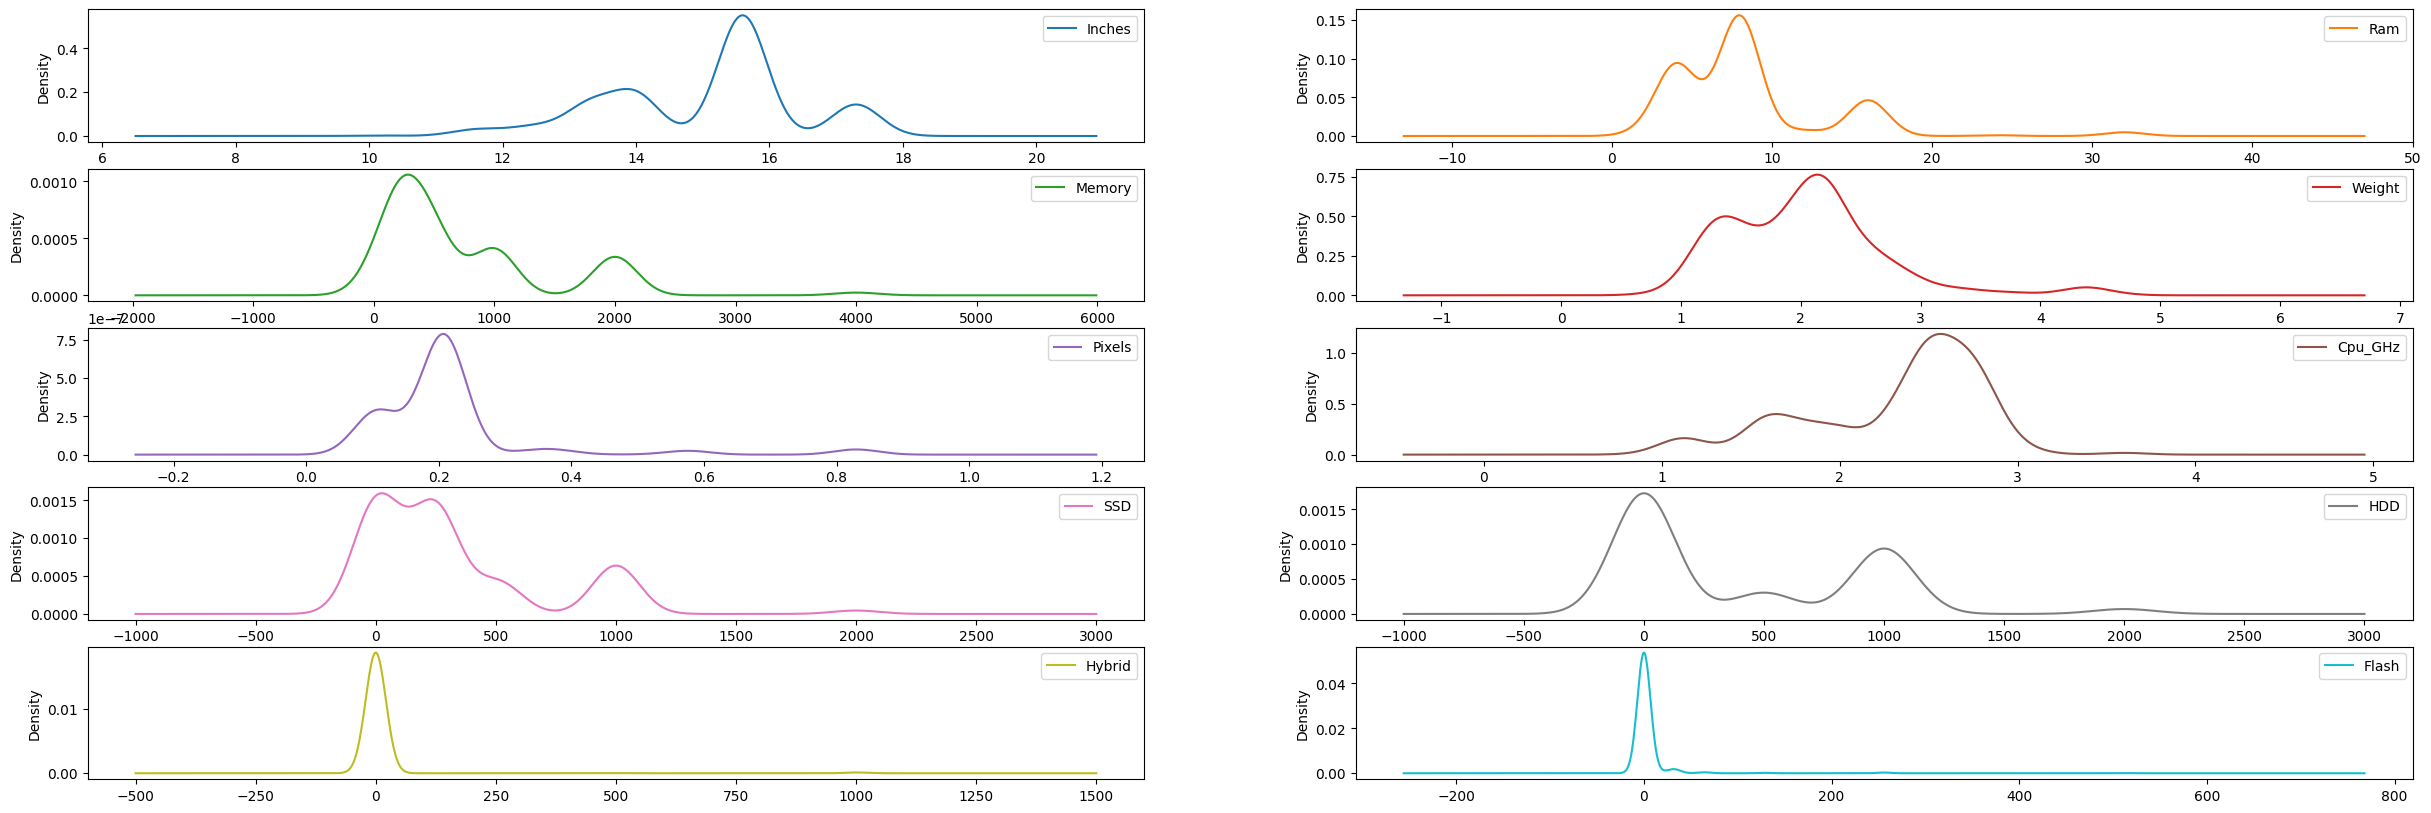

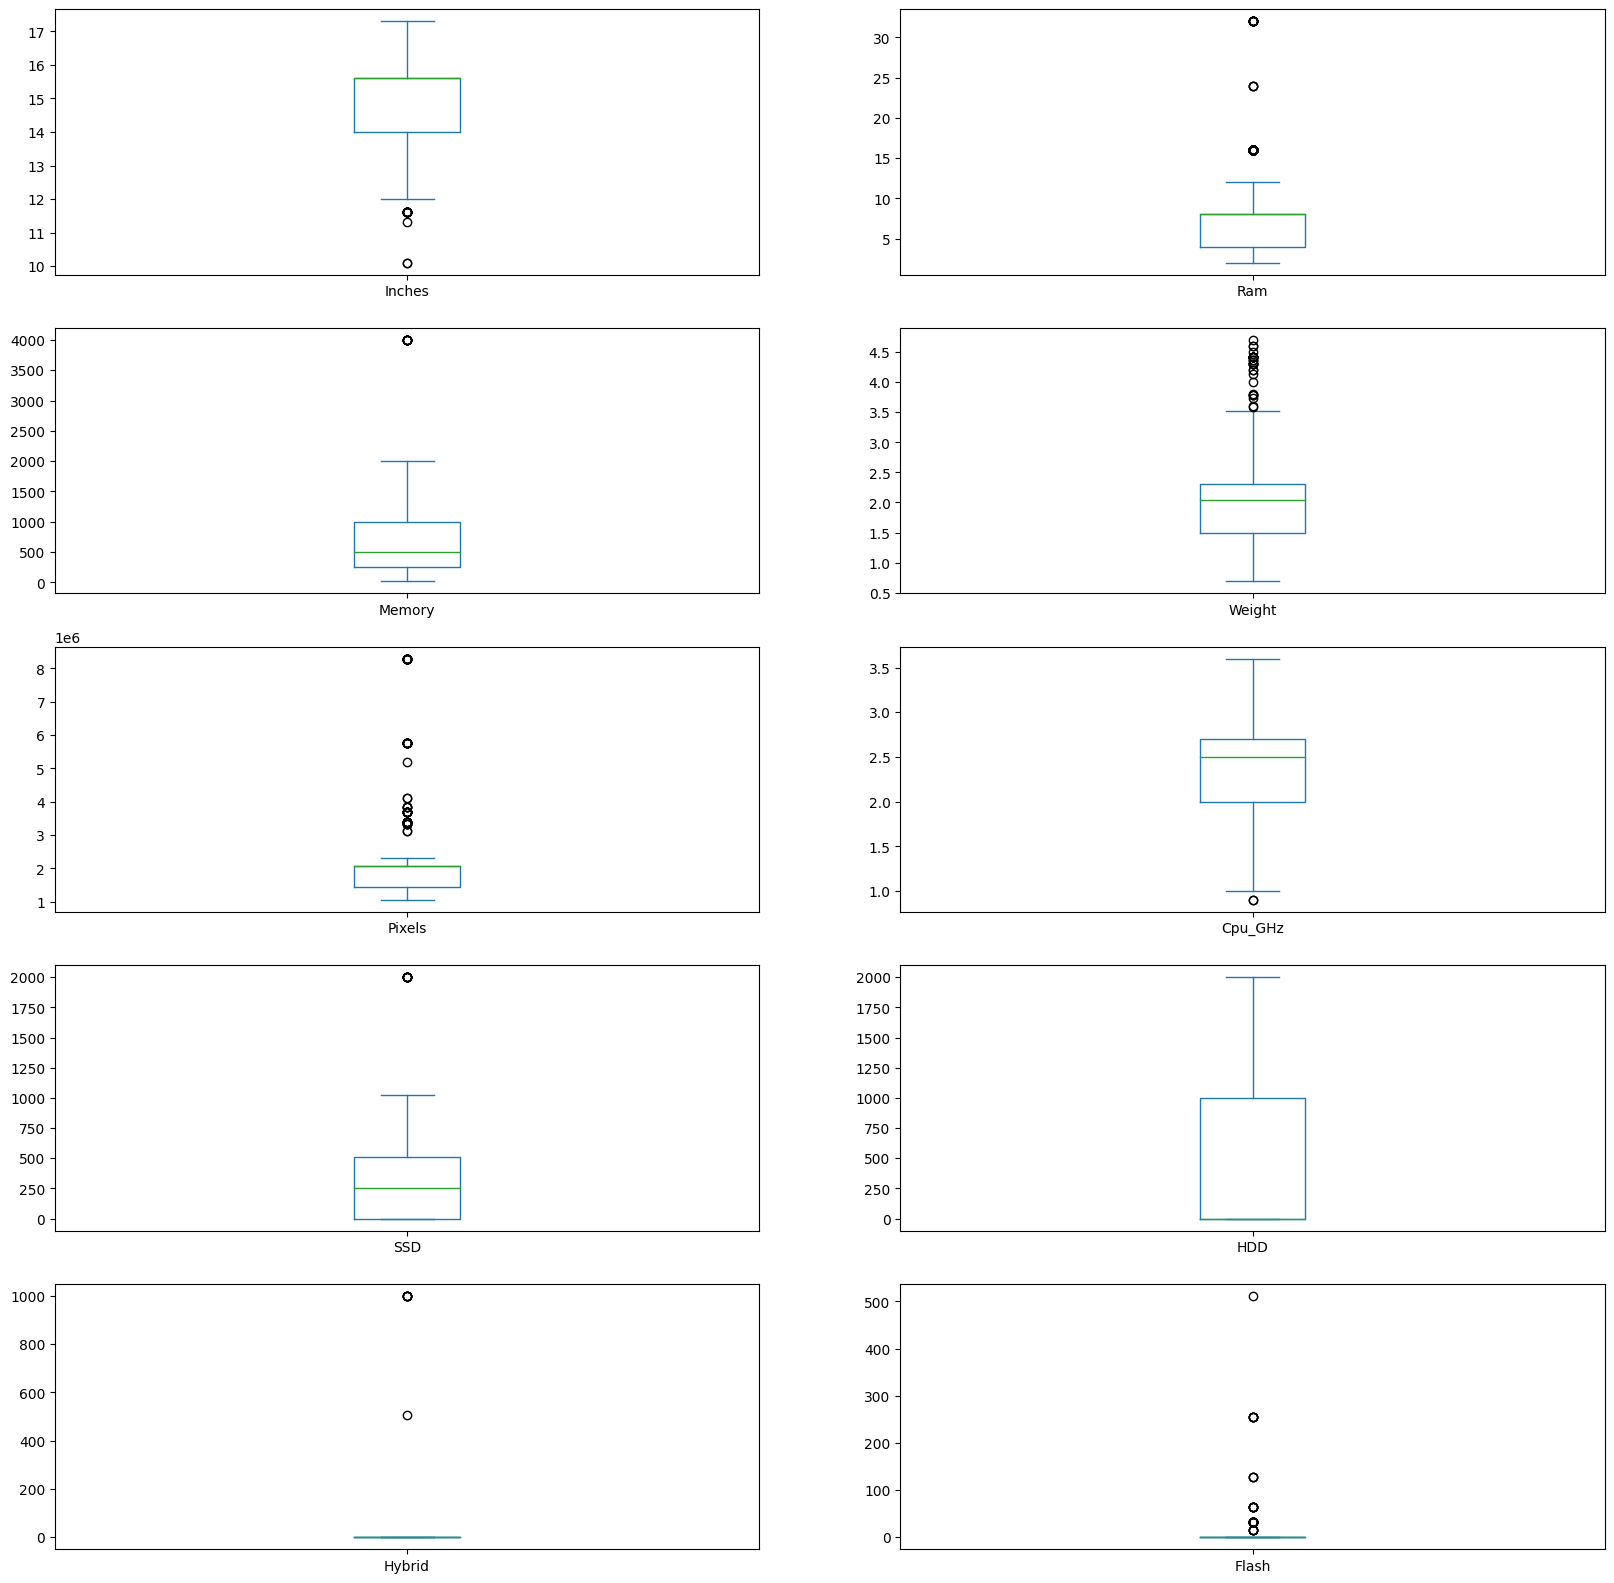

In [6]:
df_kde_box = x_data[["Inches", "Ram", "Memory", "Weight", "Pixels", "Cpu_GHz", "SSD", "HDD", "Hybrid", "Flash"]]
df_kde_box.plot(kind='kde', subplots=True, figsize=(30, 10), sharex=False, layout=(5, 2))
df_kde_box.plot(kind='box', subplots=True, figsize=(20,20), layout=(5,2))

También mostramos el gráfico de densidad para las variables booleanas que hemos creado, haciendonos una idea así de la cantidad de True/False que existen

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>]], dtype=object)

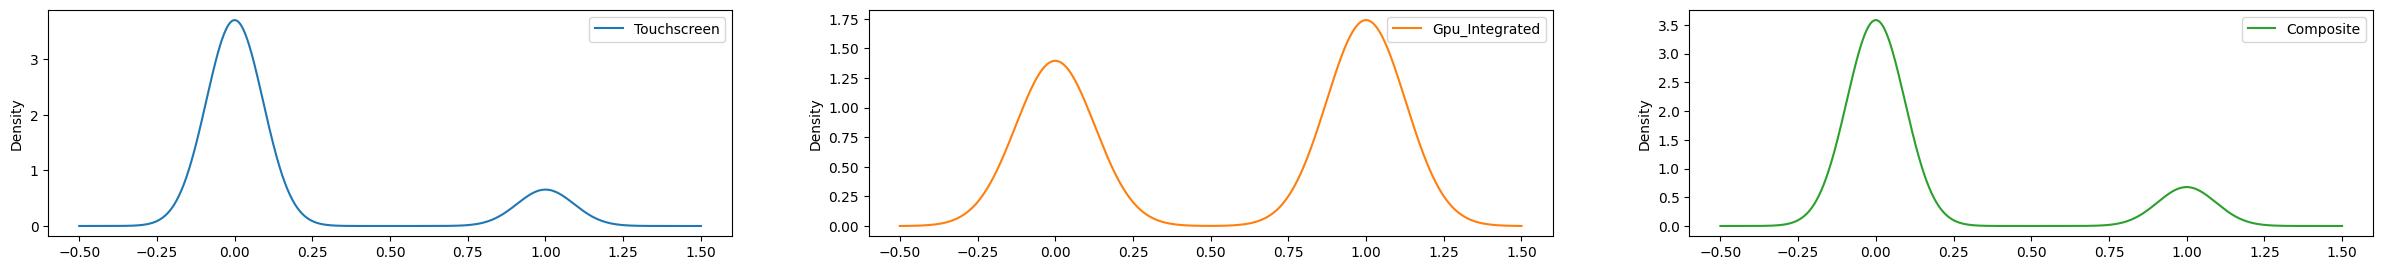

In [7]:
df_bool_distribution = x_data[["Touchscreen", "Gpu_Integrated", "Composite"]]
df_bool_distribution.plot(kind='kde', subplots=True, figsize=(30, 10), sharex=False, layout=(3, 3))

Se observan bastantes outliers en algunas features pero, sin embargo, el modelo no mejora con la eliminación de esa entrada, así que se afronta en la normalización del dataframe.

#### Features discretas
Mostramos la cantidad de valores únicos de las variables discretas para establecer un posible orden que pueda dar más peso a un valor que a otros.

In [8]:
for colname in x_data.columns:
    if isinstance(x_data[colname].dtype, object):
        print(colname + ":")
        print(x_data[colname].unique())

Company:
['Toshiba' 'HP' 'Dell' 'Lenovo' 'Asus' 'Microsoft' 'Vero' 'MSI' 'Acer'
 'Apple' 'Mediacom' 'Samsung' 'Razer' 'Google' 'Fujitsu' 'Chuwi' 'Huawei'
 'LG' 'Xiaomi']
TypeName:
['Notebook' 'Ultrabook' 'Gaming' '2 in 1 Convertible' 'Workstation'
 'Netbook']
Inches:
[13.3 15.6 12.5 14.  17.3 13.5 13.9 12.  12.3 11.6 14.1 15.  11.3 10.1
 13.  15.4 17. ]
ScreenResolution:
['Full HD 1920x1080' 'IPS PanelFull HD 1920x1080' ' 2256x1504'
 '4K Ultra HD 3840x2160' '1366x768' 'Quad HD+ 3200x1800'
 'IPS PanelRetina Display 2304x1440' '1920x1080' 'IPS Panel  2400x1600'
 '1600x900' ' 1366x768' 'IPS Panel 2560x1440'
 'IPS Panel 4K Ultra HD 3840x2160' 'IPS PanelQuad HD+ 2560x1440'
 '2560x1440' 'IPS Panel 1366x768' ' 2400x1600'
 'IPS PanelQuad HD+ 3200x1800' 'IPS Panel  2560x1440'
 'IPS PanelRetina Display 2560x1600' 'IPS Panel  1920x1200'
 'IPS PanelFull HD 2160x1440' '1440x900' 'IPS Panel  1366x768'
 'IPS PanelFull HD 1366x768' 'IPS PanelRetina Display 2880x1800'
 ' 2560x1440' 'IPS PanelFull HD 25

### Transformación de las features
Para la normalización de las features se decide que:

- En las variables discretas se utilizará el OneHotEncoder con el handle_unknown en ignore para que cuando reciba un valor desconocido, mantenga las columnas implicadas a 0 sin lanzar una excepción. Lo positivo del OneHotEncoder es que no da más peso a unos valores que a otros, pero crea muchas columnas cuando una feature tiene muchos valores.
- En algunas features que son discretas hemos usado el Ordinal encoder para asignar un orden y controlar que variables tienen más peso.
- En las variables continuas que tienen muchos outlaiers hemos usado QuantileTransformer y RobustScaler que mitigan los efectos de estos outliers.
- En el resto de variables continuas hemos usado el StandarScaler.

In [9]:
from sklearn.preprocessing import *

ct = sklearn.compose.ColumnTransformer(transformers=[
    ("Company", OneHotEncoder(handle_unknown='ignore'), [0]),
    ("TypeName", OneHotEncoder(handle_unknown='ignore'), [1]),
    ("Inches", RobustScaler(), [2]),
    ("ScreenResolution", "drop", [3]),
    ("Cpu", "drop", [4]),
    ("Ram", QuantileTransformer(n_quantiles=x_data.shape[0]), [5]),
    ("Memory", StandardScaler(), [6]),
    ("Gpu", "drop", [7]),
    ("OpSys", OneHotEncoder(handle_unknown='ignore'), [8]),
    ("Weight", StandardScaler(), [9]),
    ("IPS", OneHotEncoder(handle_unknown='ignore'), [10]),
    ("Touchscreen", OneHotEncoder(handle_unknown='ignore'), [11]),
    ("ScreenType", OneHotEncoder(handle_unknown='ignore'), [12]),
    ("Pixels", StandardScaler(), [13]),
    ("Cpu_GHz", PowerTransformer(), [14]),
    ("Cpu_Manufacturer", OrdinalEncoder(
        categories=[["Samsung", "AMD", "Intel"]]), [15]),
    ("Cpu_Model", OneHotEncoder(handle_unknown='ignore'), [16]),
    ("Gpu_Manufacturer", OrdinalEncoder(
        categories=[["ARM", "Intel", "AMD", "Nvidia"]]), [17]),
    ("Gpu_Model", OneHotEncoder(handle_unknown='ignore'), [18]),
    ("Gpu_Integrated", OneHotEncoder(handle_unknown='ignore'), [19]),
    ("SSD", QuantileTransformer(n_quantiles=x_data.shape[0]), [20]),
    ("HDD", QuantileTransformer(n_quantiles=x_data.shape[0]), [21]),
    ("Hybrid", StandardScaler(), [22]),
    ("Flash", StandardScaler(), [23]),
    ("Composite", OneHotEncoder(handle_unknown='ignore'), [24])
])

x_data = ct.fit_transform(x_data).toarray()


## Elección de regresores
Para la elección del regresor que mejor se ajuste, hemos buscado los mejores hiperparámetros con GridSearchCV y hemos comparado las puntuaciones de algunos de ellos.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

alpha = [int(x) for x in np.linspace(10, 100, num=10)]
fit_intercept = [True, False]
normalize = [True, False]
copy_X = [True, False]
max_iter = [1, 5, 10]

param_grid_ridge = {'alpha': alpha,
                'fit_intercept': fit_intercept,
                'normalize': normalize,
                'copy_X': copy_X,
                'max_iter': max_iter,
                'solver': ['auto', 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag', 'saga', 'lbfgs']}

ridge_grid = GridSearchCV(estimator=Ridge(), param_grid=param_grid_ridge, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=2)

ridge_grid.fit(x_data, y_data)
ridge_grid.best_params_


Fitting 10 folds for each of 1680 candidates, totalling 16800 fits


c:\Users\alexg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
4800 fits failed out of a total of 16800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2400 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alexg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alexg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py", line 1130, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "c:\Users\alexg\AppData\Local\Programs\Python\

{'alpha': 10,
 'copy_X': True,
 'fit_intercept': False,
 'max_iter': 1,
 'normalize': True,
 'solver': 'auto'}

In [11]:
from sklearn.linear_model import ElasticNet

param_grid_eNet = {"max_iter": [1, 5, 10],
                "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                "l1_ratio": np.arange(0.0, 1.0, 0.1)}

eNet_grid = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid_eNet, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, verbose=2)
eNet_grid.fit(x_data, y_data)
eNet_grid.best_params_

Fitting 10 folds for each of 210 candidates, totalling 2100 fits


c:\Users\alexg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.186e+07, tolerance: 4.534e+04
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.01, 'l1_ratio': 0.7000000000000001, 'max_iter': 10}

In [12]:
from sklearn.ensemble import RandomForestRegressor

param_grid_rForest = {
    'bootstrap': [True, False],
    'max_depth': [None],
    'max_features': [18,19,20],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600]
}

rForest_grid = GridSearchCV(
    estimator=RandomForestRegressor(), param_grid=param_grid_rForest, cv=10, n_jobs=-1, verbose=2)

rForest_grid.fit(x_data, y_data)
rForest_grid.best_params_


Fitting 10 folds for each of 162 candidates, totalling 1620 fits


{'bootstrap': False,
 'max_depth': None,
 'max_features': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}

In [13]:
from sklearn.linear_model import *
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import *
from sklearn.model_selection import cross_val_score

ridge = Ridge( alpha= 10, copy_X= True, fit_intercept= False, max_iter= 1, normalize= True, solver= 'auto', random_state=42)
eNet = ElasticNet(alpha=0.01, l1_ratio=0.7, max_iter=10, random_state=42)
rForest = RandomForestRegressor(bootstrap = False, max_depth = None, max_features = 19, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 400, random_state=42)
polyRidge = Pipeline([('poly', PolynomialFeatures(degree=2)), ('Ridge', Ridge( alpha= 10, copy_X= True, fit_intercept= False, max_iter= 1, normalize= True, solver= 'auto', random_state=42))])
voting = VotingRegressor([('1', polyRidge), ('2', rForest)])

regs = {
    "Ridge": ridge,
    "eNet": eNet,
    "rForest": rForest,
    "polyRidge": polyRidge,
    "Voting": voting,
}

scores = {
    "MAE": [],
    "R2": []
}

for reg in regs.values():
    reg.fit(x_data, y_data)
    scores["MAE"].append(
        np.mean(np.abs(cross_val_score(reg, x_data, y_data,
            cv=10, scoring='neg_mean_absolute_error'))))
    scores["R2"].append(
        np.mean(np.abs(cross_val_score(reg, x_data, y_data, cv=10, scoring="r2"))))

scores = pd.DataFrame(scores, index=regs.keys())

scores

c:\Users\alexg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
c:\Users\alexg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

,MAE,R2
Ridge,230.515601,0.758444
eNet,225.115712,0.768890
rForest,171.752685,0.841138
polyRidge,177.482932,0.834287
Voting,163.629943,0.853595


## Asignación regresor
Tras comparar los regresores, vemos que el Voting con polynomial features + Ridge junto con el RandomForest es el que mejor métrica tiene tanto para el MAE como en el R2

In [14]:
reg = voting.fit(x_data, y_data)

c:\Users\alexg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


## Predicción
Finalmente, cargamos el dataframe del test, guardamos el ID, preprocesamos con la función que hemos creado antes y transformamos las columnas para que estén del mismo modo que el dataframe de entrenamiento y creamos la predicción.

In [15]:
test_data = pd.read_csv("./Data/test.csv")

id_test = test_data["LaptopId"]

test_data = preprocess(test_data)

test_data = ct.transform(test_data).toarray()

y_test_pred = reg.predict(test_data)

prediction = pd.DataFrame(id_test, columns=['LaptopId'])
prediction["Price"] = y_test_pred
prediction.to_csv('./Data/prediction.csv', index=False)
prediction

,LaptopId,Price
0,891,2094.965793
1,1149,1622.293126
2,962,1037.629530
3,1204,1171.575518
4,1139,1497.730111
...,...,...
386,268,959.582660
387,1278,389.660314
388,299,1684.534092
389,162,781.034470
